### Machine learning algorithm grid search parameter tuning，Includes random forests、xgboost、lightgbm

## Random Forest

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os, sys
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import Function
import Encoding
from tqdm import tqdm

In [2]:
parent_dir = os.path.abspath(os.path.dirname(os.getcwd()))

In [4]:
DeepLearn = 1
MachineLearn = 0

In [5]:
trainfilepath = os.path.join(parent_dir, r'Data\five_fold_cross_validation.csv')
testfilepath = os.path.join(parent_dir, r'Data\independent.csv')

In [6]:
X, y = Encoding.EAAC(trainfilepath, MachineLearn)
x_test, y_test = Encoding.EAAC(testfilepath, MachineLearn)

In [7]:
X.shape

(67090, 700)

In [8]:
x_test.shape

(7456, 700)

In [ ]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []
# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in tqdm(range(200,400,10)):
    rfc = RandomForestClassifier(n_estimators=i, bootstrap=True, oob_score=True, n_jobs=6)
    score = cross_val_score(rfc, X, y, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)

In [32]:
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+200))

最大得分：0.6714413474437323 子树数量为：370


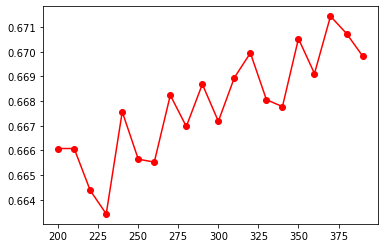

In [18]:
# 绘制学习曲线
x = np.arange(200,400,10)
plt.subplot(111)
plt.plot(x, score_lt, marker='o', color='red')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [42:47<00:00, 256.72s/it]

最优参数以及最高得分: [37.          0.67078551]


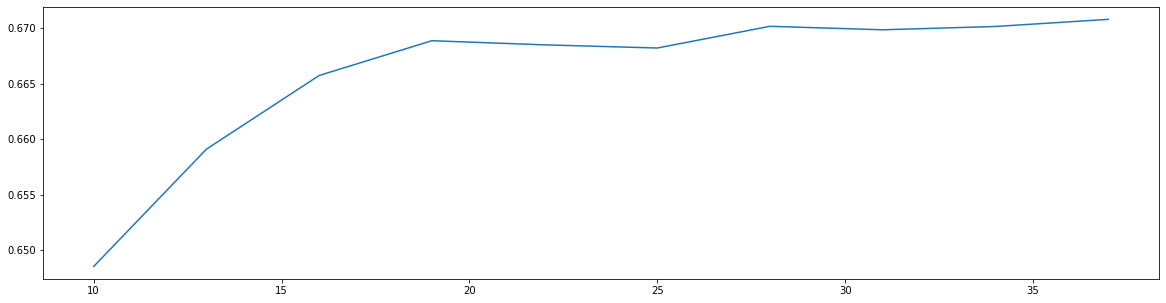

In [36]:
###粗调max_depth参数
ScoreAll = []
for i in tqdm(range(10,40,3)):
    rfc = RandomForestClassifier(n_estimators=370, bootstrap=True, oob_score=True, max_depth=i, n_jobs=6)
    score = cross_val_score(rfc, X, y, cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [36:38<00:00, 274.78s/it]

最优参数以及最高得分: [7.        0.6718587]


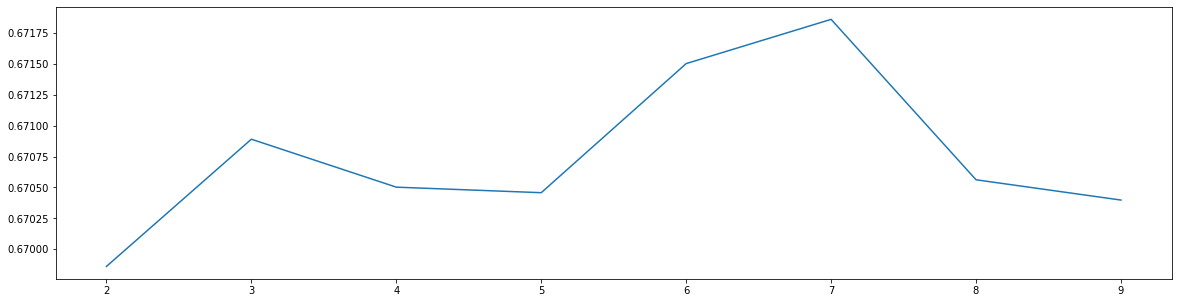

In [38]:
###调min_samples_split参数
ScoreAll = []
for i in tqdm(range(2,10)):
    rfc = RandomForestClassifier(n_estimators=370, bootstrap=True, oob_score=True, min_samples_split=i, n_jobs=6)
    score = cross_val_score(rfc, X, y, cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

最优参数以及最高得分: [1.         0.67088985]


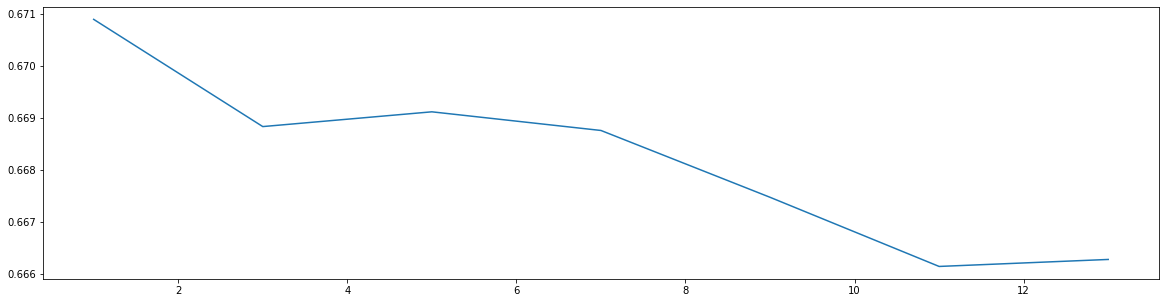

In [40]:
###调min_samples_leaf参数
ScoreAll = []
for i in range(1,15,2):
    rfc = RandomForestClassifier(n_estimators=370, bootstrap=True, oob_score=True, min_samples_split=7,min_samples_leaf=i, n_jobs=6)
    score = cross_val_score(rfc, X, y, cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [15]:
###调max_features参数
ScoreAll = []
values = ['auto', 'sqrt', 'log2']
for i in tqdm(values):
    rfc = RandomForestClassifier(n_estimators=370, bootstrap=True, oob_score=True, min_samples_split=7,min_samples_leaf =1,max_features=i, n_jobs=6)
    score = cross_val_score(rfc, X, y, cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [10:21<00:00, 207.09s/it]


In [14]:
ScoreAll

array([['auto', '0.6712773885825011'],
       ['sqrt', '0.6718885079743628'],
       ['log2', '0.659472350573856']], dtype='<U32')

### 最终参数 n_estimators=370,max_features='sqrt',max_depth=default,min_samples_split=7,min_samples_leaf=1

## LighGBM

In [52]:
from lightgbm import LGBMClassifier

In [86]:
model = LGBMClassifier(boosting_type='gbdt',
                        objective = 'binary',
                        is_unbalance = False,
                        metric = 'binary_logloss,auc',
                        max_depth = 25,
                        num_leaves = 51,
                        learning_rate = 0.05,
                        feature_fraction = 0.7,
                        min_child_samples=20,
                        min_child_weight=0.001,
                        bagging_fraction = 1,
                        bagging_freq = 1,
                        reg_alpha = 0.9,
                        reg_lambda = 10,
                        cat_smooth = 0,
                        num_iterations = 450,   
                        )

### Step 1 调整max_depth 和 num_leaves

In [47]:
parameters = {
    'max_depth': [7,12,17,25,-1],
    'num_leaves': [11,21,31,41,51],
}

In [50]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 25 candidates, totalling 125 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
参数的最佳取值:{'max_depth': 25, 'num_leaves': 51}
最佳模型得分:0.7510558882679425
[0.73470933 0.74340263 0.74483436 0.74511292 0.74536251 0.73517622
 0.7451946  0.74903493 0.74855573 0.74975632 0.73517622 0.74608989
 0.74883961 0.74956023 0.75067058 0.73517622 0.74608989 0.74842875
 0.75001033 0.75105589 0.73517622 0.74608989 0.74842875 0.75001033
 0.75105589]
[{'max_depth': 7, 'num_leaves': 11}, {'max_depth': 7, 'num_leaves': 21}, {'max_depth': 7, 'num_leaves': 31}, {'max_depth': 7, 'num_leaves': 41}, {'max_depth': 7, 'num_leaves': 51}, {'max_depth': 12, 'num_leaves': 11}, {'max_depth': 12, 'num_leaves': 21}, {'max_depth': 12, 'num_leaves': 31}, {'max_depth': 12

### Step2 调整min_child_samples 和 min_child_weight

In [54]:
parameters = {
    'min_child_samples': [16,18,20,22,24],
    'min_child_weight': [0.001,0.002],
}

In [55]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


参数的最佳取值:{'min_child_samples': 20, 'min_child_weight': 0.001}
最佳模型得分:0.7510558882679425
[0.74960188 0.74960188 0.75093938 0.75093938 0.75105589 0.75105589
 0.75069937 0.75069937 0.75068357 0.75068357]
[{'min_child_samples': 16, 'min_child_weight': 0.001}, {'min_child_samples': 16, 'min_child_weight': 0.002}, {'min_child_samples': 18, 'min_child_weight': 0.001}, {'min_child_samples': 18, 'min_child_weight': 0.002}, {'min_child_samples': 20, 'min_child_weight': 0.001}, {'min_child_samples': 20, 'min_child_weight': 0.002}, {'min_child_samples': 22, 'min_child_weight': 0.001}, {'min_child_samples': 22, 'min_child_weight': 0.002}, {'min_child_samples': 24, 'min_child_weight': 0.001}, {'min_child_samples': 24, 'min_child_weight': 0.002}]


### Step 3 调整feature_fraction

In [56]:
parameters = {
    'feature_fraction': [0.6,0.7,0.8,0.9,1],
}

In [57]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


参数的最佳取值:{'feature_fraction': 0.7}
最佳模型得分:0.7511819694529838
[0.7495544  0.75118197 0.74972759 0.75097743 0.75105589]
[{'feature_fraction': 0.6}, {'feature_fraction': 0.7}, {'feature_fraction': 0.8}, {'feature_fraction': 0.9}, {'feature_fraction': 1}]


### Step 4 调整bagging_fraction和bagging_freq

In [61]:
# bagging_fraction+bagging_freq参数必须同时设置，bagging_fraction相当于subsample样本采样，可以使bagging更快的运行，同时也可以降拟合
# bagging_freq默认0，表示bagging的频率，0意味着没有使用bagging，k意味着每k轮迭代进行一次bagging
parameters = {
     'bagging_fraction': [0.7,0.8,0.9,1],
     'bagging_freq': [1,2,3,4],
}

In [62]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


参数的最佳取值:{'bagging_fraction': 1, 'bagging_freq': 1}
最佳模型得分:0.7511819694529838
[0.74773455 0.74648318 0.74618396 0.74675243 0.74894934 0.74821649
 0.74924916 0.74996878 0.75089608 0.74875802 0.74897888 0.75014989
 0.75118197 0.75118197 0.75118197 0.75118197]
[{'bagging_fraction': 0.7, 'bagging_freq': 1}, {'bagging_fraction': 0.7, 'bagging_freq': 2}, {'bagging_fraction': 0.7, 'bagging_freq': 3}, {'bagging_fraction': 0.7, 'bagging_freq': 4}, {'bagging_fraction': 0.8, 'bagging_freq': 1}, {'bagging_fraction': 0.8, 'bagging_freq': 2}, {'bagging_fraction': 0.8, 'bagging_freq': 3}, {'bagging_fraction': 0.8, 'bagging_freq': 4}, {'bagging_fraction': 0.9, 'bagging_freq': 1}, {'bagging_fraction': 0.9, 'bagging_freq': 2}, {'bagging_fraction': 0.9, 'bagging_freq': 3}, {'bagging_fraction': 0.9, 'bagging_freq': 4}, {'bagging_fraction': 1, 'bagging_freq': 1}, {'bagging_fraction': 1, 'bagging_freq': 2}, {'bagging_fraction': 1, 'bagging_freq': 3}, {'bagging_fraction': 1, 'bagging_freq': 4}]


### Step 5 调整lambda_l1(reg_alpha)和lambda_l2(reg_lambda)

In [64]:
parameters = {
     'reg_alpha': [0,0.5,0.8,0.9,1],
     'reg_lambda': [0,0.1,0.5,1,4,8],
}

In [65]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


参数的最佳取值:{'reg_alpha': 0.9, 'reg_lambda': 8}
最佳模型得分:0.7536928801410493
[0.75118197 0.75003636 0.75051488 0.75108232 0.75284574 0.75265314
 0.75220582 0.75219804 0.75161364 0.75223707 0.75274616 0.75308158
 0.75245643 0.75220668 0.75232661 0.75309863 0.75348688 0.75339856
 0.75296647 0.75236998 0.75271413 0.75327616 0.75290636 0.75369288
 0.75253604 0.75225197 0.75262285 0.75247451 0.75349554 0.75281136]
[{'reg_alpha': 0, 'reg_lambda': 0}, {'reg_alpha': 0, 'reg_lambda': 0.1}, {'reg_alpha': 0, 'reg_lambda': 0.5}, {'reg_alpha': 0, 'reg_lambda': 1}, {'reg_alpha': 0, 'reg_lambda': 4}, {'reg_alpha': 0, 'reg_lambda': 8}, {'reg_alpha': 0.5, 'reg_lambda': 0}, {'reg_alpha': 0.5, 'reg_lambda': 0.1}, {'reg_alpha': 0.5, 'reg_lambda': 0.5}, {'reg_alpha': 0.5, 'reg_lambda': 1}, {'reg_alpha': 0.5, 'reg_lambda': 4}, {'reg_alpha': 0.5, 'reg_lambda': 8}, {'reg_alpha': 0.8, 'reg_lambda': 0}, {'reg_alpha': 0.8, 'reg_lambda': 0.1}, {'reg_alpha': 0.8, 'reg_lambda': 0.5}, {'reg_alpha': 0.8, 'reg_lambda': 1}, {

### Step 6 调整cat_smooth

In [70]:
# cat_smooth为设置每个类别拥有最小的个数，主要用于去噪。
parameters = {
     'cat_smooth': [0,10,20],
}

In [72]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


参数的最佳取值:{'cat_smooth': 0}
最佳模型得分:0.7540482535689697
[0.75404825 0.75404825 0.75404825]
[{'cat_smooth': 0}, {'cat_smooth': 10}, {'cat_smooth': 20}]


### Step 7 ，适当调小learning_rate的值以及调整num_iterations的大小

In [73]:
parameters = {
     'learning_rate': [0.01,0.015,0.025,0.05,0.1],
    'num_iterations': [200,250,300,350,400,450],
}

In [74]:
gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gsearch.fit(X, y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


D:\Program Files\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


参数的最佳取值:{'learning_rate': 0.05, 'num_iterations': 450}
最佳模型得分:0.7617683056161714
[0.7277225  0.73352649 0.73772509 0.74106501 0.74363568 0.74584255
 0.73729102 0.74193949 0.74525242 0.748098   0.75041955 0.75239964
 0.74713537 0.75107694 0.75387657 0.75594281 0.75768887 0.75881977
 0.75692372 0.75864649 0.75963876 0.7604252  0.76116478 0.76176831
 0.75839432 0.75908838 0.75941135 0.75935724 0.75965519 0.75966193]
[{'learning_rate': 0.01, 'num_iterations': 200}, {'learning_rate': 0.01, 'num_iterations': 250}, {'learning_rate': 0.01, 'num_iterations': 300}, {'learning_rate': 0.01, 'num_iterations': 350}, {'learning_rate': 0.01, 'num_iterations': 400}, {'learning_rate': 0.01, 'num_iterations': 450}, {'learning_rate': 0.015, 'num_iterations': 200}, {'learning_rate': 0.015, 'num_iterations': 250}, {'learning_rate': 0.015, 'num_iterations': 300}, {'learning_rate': 0.015, 'num_iterations': 350}, {'learning_rate': 0.015, 'num_iterations': 400}, {'learning_rate': 0.015, 'num_iterations': 450}, 

### 最终参数 
### num_iterations=450,learning_rate=0.05,max_depth = 25,num_leaves = 51
### feature_fraction = 0.7,min_child_samples=20,min_child_weight=0.001
### bagging_fraction = 1,bagging_freq = 1,reg_alpha = 0.9,reg_lambda = 10,cat_smooth = 0